In [2]:
import torch
x,y=torch.load('corn9train')
x1,y1=torch.load('corn9valid')
x2,y2=torch.load('corn9test')

print(f'train:{len(y)-sum(y)}<->{sum(y)}   valid:{len(y1)-sum(y1)}<->{sum(y1)}  test:{len(y2)-sum(y2)}<->{sum(y2)}')

train:201889<->1070628   valid:67923<->365167  test:29192<->118221


In [3]:
import torch
import torchvision
import os
import sys
Xtrain,ytrain=torch.load('corn9train')
Xtest,ytest=torch.load('corn9valid')
types={0:'road',1:'field'}

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
#可视化图像


#MLP-mixer
import torch
from torch import nn
SIZE=5
P=1
CHANNELS=192
PATCHES=int((SIZE/P)**2)
#可调隐藏宽度DS DC
DS=96
DC=768

class TokenMixer(nn.Module):
    def __init__(self):
        global PATCHES,DS,CHANNELS
        super().__init__()
        self.tokenblock=nn.Sequential(
            nn.Linear(PATCHES,DS),
            nn.BatchNorm1d(CHANNELS),
            nn.GELU(),
            nn.Dropout(),
            nn.Linear(DS,PATCHES),
            )
            
    def forward(self,x):
        return self.tokenblock(x)
    
class ChannelMixer(nn.Module):
    def __init__(self):
        global CHANNELS,DC,PATCHES
        super().__init__()
        self.channelblock=nn.Sequential(
            nn.Linear(CHANNELS,DC),
            nn.BatchNorm1d(PATCHES),
            nn.GELU(),
            nn.Dropout(),
            nn.Linear(DC,CHANNELS),
            )
        
    def forward(self,x):
        return self.channelblock(x)
class MixerLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_mixing=TokenMixer()
        self.channel_mixing=ChannelMixer()
        
    def forward(self,x):#patches*channels
        global CHANNELS
        y=nn.LayerNorm(CHANNELS)(x)
        y=torch.permute(y,(0,2,1))
        y=self.token_mixing(y)
        y=torch.permute(y,(0,2,1))
        x=x+y
        y=nn.LayerNorm(CHANNELS)(x)
        y=self.channel_mixing(y)
        return x+y
from typing import OrderedDict
class Mixer(nn.Module):
    def __init__(self,num):
        global CHANNELS,PATCHES,P
        super().__init__()
        self.patch_connect=nn.Conv2d(9, CHANNELS, P,stride=P)
        blocks=OrderedDict()
        for i in range(num):
            blocks['MixerLayer '+str(i)]=MixerLayer()
        self.mixerblocks=nn.Sequential(blocks)
        self.full_connect=nn.Linear(PATCHES,2)
        
    def forward(self,x):
        global CHANNELS,PATCHES
        y=nn.BatchNorm2d(9)
        y=self.patch_connect(x)
        y=nn.Flatten(start_dim=2)(y)#channels*patches
        y=torch.permute(y, (0,2,1))
        y=self.mixerblocks(y)
        y=nn.LayerNorm(CHANNELS)(y)
        #全局最大池化
        y=nn.MaxPool1d(CHANNELS)(y)
        y=nn.Flatten()(y)
        y=self.full_connect(y)
        return y
    

In [5]:
#数据预加载
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import Compose,ToTensor,Lambda,Normalize,Resize
class Mydata(Dataset):
    def __init__(self,X,y):
        self.X=X
        self.target_transform=Lambda(lambd=lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, y.clone().detach(), value=1))
        self.y=y
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        data=torch.reshape(self.X[idx],(5,5,9))
        data=torch.permute(data,(2,0,1))
        label=self.target_transform(self.y[idx])
        return data.float(),label.float()
    

In [6]:
traindata=Mydata(Xtrain,ytrain)
testdata=Mydata(Xtest,ytest)

trainloader=DataLoader(traindata,batch_size=2048,shuffle=True)
testloader=DataLoader(testdata,batch_size=2048,shuffle=False)

In [7]:
from torch.nn import CrossEntropyLoss,init
from torch.optim import Adam,SGD,lr_scheduler
from torch.nn.utils import clip_grad_norm_

mixer=Mixer(12).to('cuda')

# 自定义初始化
for name,params in mixer.named_parameters():
    init.normal_(params)
mixer.load_state_dict(torch.load('../mixer_tractor_v1.params'))

<All keys matched successfully>

In [12]:
#torch.save(mixer.state_dict(),'../mixer_corn_v1.params') 

# Finetuning

In [8]:
Xtest,ytest=torch.load('corn9valid')
traindata=Mydata(Xtrain,ytrain)
testdata=Mydata(Xtest,ytest)

trainloader=DataLoader(traindata,batch_size=2048,shuffle=True)
testloader=DataLoader(testdata,batch_size=2048,shuffle=False)


epoch 1 start
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

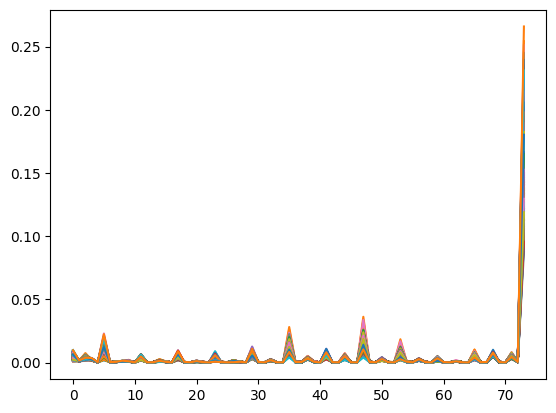


train loss:0.5058497442501534
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
test accuracy:0.8386386201482371

epoch 2 start
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [ ]:
loss_fn=CrossEntropyLoss()#Softmax included
optimizer=SGD(mixer.parameters(),lr=0.01)
epoches=20
scheduler=lr_scheduler.LinearLR(optimizer,start_factor=1,end_factor=0.05,total_iters=epoches*len(trainloader))
losslist=[]
for i in range(epoches):
    print(f'\nepoch {i+1} start')
    avgloss=0
    mixer.train()
    for idx,(X,y) in enumerate(trainloader):
        with torch.device('cuda'):
            torch.cuda.empty_cache()
            pred=mixer(X.to('cuda'))
            loss=loss_fn(pred,y.to('cuda'))
            loss.backward()
            biasmaxlist=[]
            weightmaxlist=[]
            for name,params in mixer.named_parameters():
                if 'bias' in name:
                    biasmaxlist.append(params.grad.max().item())
                else:
                    weightmaxlist.append(params.grad.max().item())
            clip_grad_norm_(mixer.parameters(), max_norm=1,norm_type=1)#gradient-clipping  if ratio>1,then scale return total_norm
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            avgloss+=loss.item()
            print(end='>')
            plt.plot(weightmaxlist)
    plt.show()
    avgloss=avgloss/(idx+1)
    print(f'\ntrain loss:{avgloss}')
    losslist.append(avgloss)
    
    
    torch.cuda.empty_cache()
    mixer.eval()
    acc=0
    acclist1=[]
    avgloss1=0
    loss_fn=CrossEntropyLoss()#Softmax included
    # y_pred=[]
    # y_true=ytest
    with torch.no_grad():   
        for idx,(X,y) in enumerate(testloader):
            with torch.device('cuda'):
                pred=mixer(X.to('cuda'))
                avgloss1+=loss_fn(pred,y.to('cuda')).item()
                acc+=sum(pred.argmax(dim=1)==y.to('cuda').argmax(dim=1)).item()
            # y_pred+=pred.argmax(dim=1).tolist()
            print(end='>')
        acc/=len(testloader.dataset)
        acclist1.append(acc)
        print(f'\ntest accuracy:{acc}')
    
# torch.save(mixer.state_dict(),'../MixerReplication/mixer.params') 

# Result

In [7]:
Xtest,ytest=torch.load('corn9test')
testdata=Mydata(Xtest,ytest)
testloader=DataLoader(testdata,batch_size=2048,shuffle=False)
torch.cuda.empty_cache()
mixer.eval()
acc=0
acclist1=[]
avgloss1=0
loss_fn=CrossEntropyLoss()#Softmax included
y_pred=[]
y_true=ytest
with torch.no_grad():   
    for idx,(X,y) in enumerate(testloader):
        with torch.device('cuda'):
            pred=mixer(X.to('cuda'))
            avgloss1+=loss_fn(pred,y.to('cuda')).item()
            acc+=sum(pred.argmax(dim=1)==y.to('cuda').argmax(dim=1)).item()
        y_pred+=pred.argmax(dim=1).tolist()
        print(end='>')
    acc/=len(testloader.dataset)
    acclist1.append(acc)
    print(f'\ntest accuracy:{acc}')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
test accuracy:0.6408593543310291


In [8]:
import sklearn
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.28      0.53      0.37     29192
           1       0.85      0.67      0.75    118221

    accuracy                           0.64    147413
   macro avg       0.57      0.60      0.56    147413
weighted avg       0.74      0.64      0.67    147413



In [11]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true,y_pred))

[[ 13824  15368]
 [  1365 116856]]


In [ ]:
import sklearn
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true,y_pred))